In [3]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2024-05-23 01:20:04--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2024-05-23 01:20:04 (4.74 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


# Data manipulation

In [5]:
dataset = pd.read_csv('insurance.csv')

# Transforming categorical data into numerical
dataset.sex = pd.Categorical(dataset.sex).codes
dataset.smoker = pd.Categorical(dataset.smoker).codes
dataset.region = pd.Categorical(dataset.region).codes

dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,1,31.0,3,0,1,10600.55
1334,18,0,31.9,0,0,0,2205.98
1335,18,0,36.9,0,0,2,1629.83
1336,21,0,25.8,0,0,3,2007.95
1337,61,0,29.1,0,1,1,29141.36


In [6]:
np_dataset = dataset.to_numpy()
print(np_dataset.shape)

# Separating 80% of the data to become training and the rest to become test
total_data = np_dataset.shape[0]
eighty_percent = int(total_data * 0.8)
train_dataset, test_dataset = np_dataset[:eighty_percent], np_dataset[eighty_percent:]
print(train_dataset.shape, test_dataset.shape)

(1338, 7)
(1070, 7) (268, 7)


In [7]:
# Extracting the labels from the dataset
def extract_labels(dataset):
  dataset = dataset.T
  x = dataset[0:6].T
  y = dataset[-1]
  print(x.shape, y.shape)
  return x.astype(np.float16), y.astype(np.float16)

train_dataset, train_labels = extract_labels(train_dataset)
test_dataset, test_labels = extract_labels(test_dataset)

(1070, 6) (1070,)
(268, 6) (268,)


# Creating the model and training

In [8]:
# Print the current epoch each N epochs
class print_epoch_result(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if (epoch+1) % 50 == 0:
      print(f"Epoch: {epoch+1} - loss: {logs['loss']} - mae: {logs['mae']} - mse: {logs['mse']}")

# When finishing training, show what was the last epoch and its results
class MyEarlyStopping(keras.callbacks.EarlyStopping):
  def __init__(self, monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False):
    super().__init__(monitor, min_delta, patience, verbose, mode, baseline, restore_best_weights)

  def on_train_end(self, logs=None):
    print(f"Epoch: {self.stopped_epoch+1} - loss: {logs['loss']} - mae: {logs['mae']} - mse: {logs['mse']}")


early_stopping = MyEarlyStopping(monitor='mae', patience=20, mode="min", restore_best_weights=True)

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath="lowest_mae.h5",
    monitor='mae',
    save_best_only=True,
    mode='min',
    verbose=0
)

In [9]:
# Defining the model
input_shape = train_dataset[0].shape

model = keras.Sequential([
  layers.Dense(64, activation='relu', input_shape=input_shape),
  layers.BatchNormalization(),
  layers.Dense(32, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2689 (10.50 KB)
Non-trainable params: 128 (512.00 Byte)
_________________________________________________________________


In [14]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01)
metrics = ["mae", "mse"]
model.compile(optimizer = optimizer, loss = 'mse', metrics=metrics)

history = model.fit(
    x = train_dataset,
    y = train_labels,
    epochs = 500,
    shuffle = True,
    verbose = 0,
    callbacks = [print_epoch_result()]
)

Epoch: 50 - loss: 21161482.0 - mae: 2757.140625 - mse: 21161482.0
Epoch: 100 - loss: 20354878.0 - mae: 2588.373779296875 - mse: 20354878.0
Epoch: 150 - loss: 21955558.0 - mae: 2626.560546875 - mse: 21955558.0
Epoch: 200 - loss: 21498040.0 - mae: 2728.255859375 - mse: 21498040.0
Epoch: 250 - loss: 21219932.0 - mae: 2664.51123046875 - mse: 21219932.0
Epoch: 300 - loss: 21285568.0 - mae: 2578.3095703125 - mse: 21285568.0
Epoch: 350 - loss: 20390140.0 - mae: 2549.3076171875 - mse: 20390140.0
Epoch: 400 - loss: 21881300.0 - mae: 2673.0009765625 - mse: 21881300.0
Epoch: 450 - loss: 20523808.0 - mae: 2608.24853515625 - mse: 20523808.0
Epoch: 500 - loss: 20390732.0 - mae: 2589.86572265625 - mse: 20390732.0


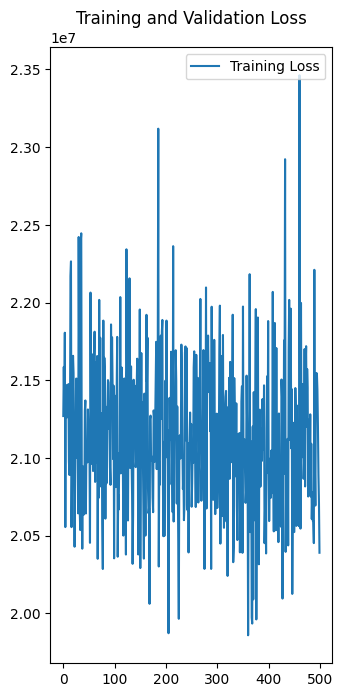

In [15]:
loss = history.history['loss']
mae = history.history['mae']

epochs_range = range(500)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Validating the model

9/9 - 0s - loss: 22504974.0000 - mae: 2560.6736 - mse: 22504974.0000 - 143ms/epoch - 16ms/step
Testing set Mean Abs Error: 2560.67 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 2ms/step


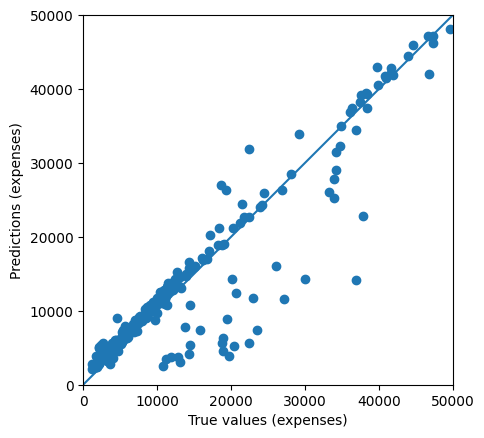

In [16]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
